In [1]:
import numpy as np
import glob
import os
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.ticker as mtick
%matplotlib inline
%pylab inline
import seaborn as sns

from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.metrics import Precision, Recall
from keras.applications import Xception, VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


C:\Users\bjane\Miniconda3\envs\learn-env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


In [11]:
# define path to save model
model_path = './VGG16_best_model.h5'

callbacks = [EarlyStopping(monitor='val_accuracy', 
                           patience=10,
                           mode='max',
                           verbose=1),
             ModelCheckpoint(model_path,
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max',
                             verbose=0)]

In [12]:
# define model evaluation
def model_evaluation(history, p_r_iteration=2):

    # set context for plots
    sns.set_style('darkgrid') 
    sns.set_context('talk') 
    
    # define number of epochs
    epochs = range(1, len(history.history['accuracy'])+1)
    
    # plot accuracy
    plt.figure(figsize=(15,8))
    pyplot.title("Accuracy") 
    ax = plt.plot(epochs, history.history['accuracy'], color='blue', label='Train Data') 
    ax = plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot recall
    plt.figure(figsize=(15,8))
    pyplot.title("Precision") 
    plt.plot(epochs, history.history['recall_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_recall_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot precision
    plt.figure(figsize=(15,8))
    pyplot.title("Recall") 
    plt.plot(epochs, history.history['precision_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_precision_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()

In [3]:
# directory path
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'

In [5]:
# create new instances for VGG16 model
generator_vgg16 = ImageDataGenerator(featurewise_center=True,
                                     validation_split=0.10,
                                     horizontal_flip=True)

generator_vgg16_test = ImageDataGenerator(featurewise_center=True)

# specify feature wise centering from ImageNet dataset
generator_vgg16.mean = [123.68, 116.779, 103.939] 
generator_vgg16_test.mean = [123.68, 116.779, 103.939] 
                                         
# Get all the data in the directory chest_xrays/train and resize
train_gen_vgg16 = generator_vgg16.flow_from_directory(
        train_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64,
        color_mode='rgb',
        subset='training')

# create a validation dataset
val_gen_vgg16 = generator_vgg16.flow_from_directory(
        train_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64,
        color_mode='rgb',
        subset='validation')

# Get all the data in the directory chest_xrays/test and resize
test_gen_vgg16 = generator_vgg16_test.flow_from_directory(
        test_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64, 
        color_mode='rgb')

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# define VGG16 model
def create_VGG16_model(classification_threshold=0.5):

    # load VGG16 model
    cnn_base = VGG16(include_top=False, input_shape=(112, 112, 3))
    
    # mark VGG16 model layers as untrainable
    cnn_base.trainable = False
    
    # initialize model
    model = Sequential()
    
    # add CNN base
    model.add(cnn_base)
    
    # add flattening layer
    model.add(Flatten())
    
    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # add dropout layer
    model.add(Dropout(0.5))
    
    # add second dense layer
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))

    # add output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

    # custom decaying optimizer
    
    #optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    opt = optimizers.SGD(lr=0.001, momentum=0.9)
    
    # compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [9]:
# create VGG16 model
VGG16_model = create_VGG16_model(classification_threshold=0.50)

In [13]:
# train model
history_VGG16 = VGG16_model.fit_generator(train_gen_vgg16, steps_per_epoch=len(train_gen_vgg16), 
                                         epochs=50, validation_data=val_gen_vgg16, validation_steps=len(val_gen_vgg16),
                                         callbacks=callbacks)

Epoch 1/50
74/74 [==============================] - 272s 4s/step - loss: 0.1309 - accuracy: 0.9517 - precision_2: 0.9692 - recall_2: 0.9656 - val_loss: 0.4497 - val_accuracy: 0.8494 - val_precision_2: 0.8109 - val_recall_2: 0.9897
Epoch 2/50
74/74 [==============================] - 263s 4s/step - loss: 0.1040 - accuracy: 0.9621 - precision_2: 0.9761 - recall_2: 0.9728 - val_loss: 1.1462 - val_accuracy: 0.7901 - val_precision_2: 0.7515 - val_recall_2: 0.9923
Epoch 3/50
74/74 [==============================] - 264s 4s/step - loss: 0.1065 - accuracy: 0.9640 - precision_2: 0.9795 - recall_2: 0.9719 - val_loss: 1.4782 - val_accuracy: 0.7388 - val_precision_2: 0.7067 - val_recall_2: 0.9949
Epoch 4/50
74/74 [==============================] - 271s 4s/step - loss: 0.1009 - accuracy: 0.9646 - precision_2: 0.9795 - recall_2: 0.9728 - val_loss: 1.3930 - val_accuracy: 0.8061 - val_precision_2: 0.7653 - val_recall_2: 0.9949
Epoch 5/50
74/74 [==============================] - 272s 4s/step - loss: 0.0

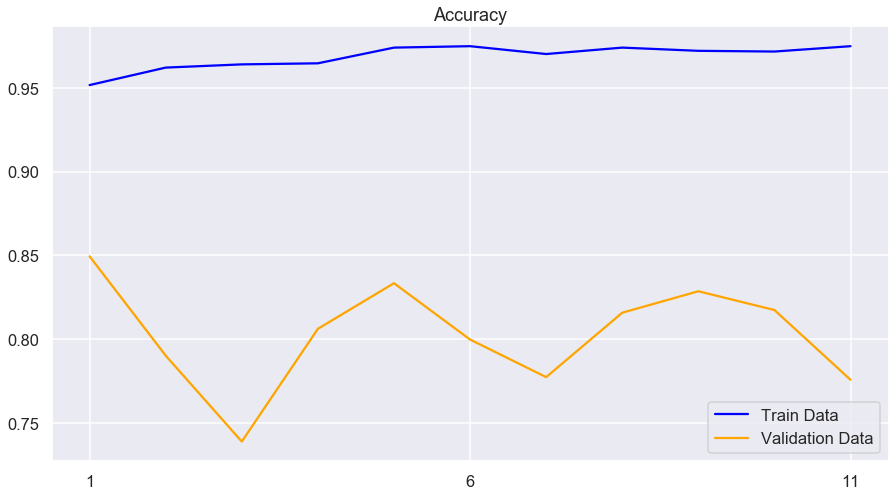

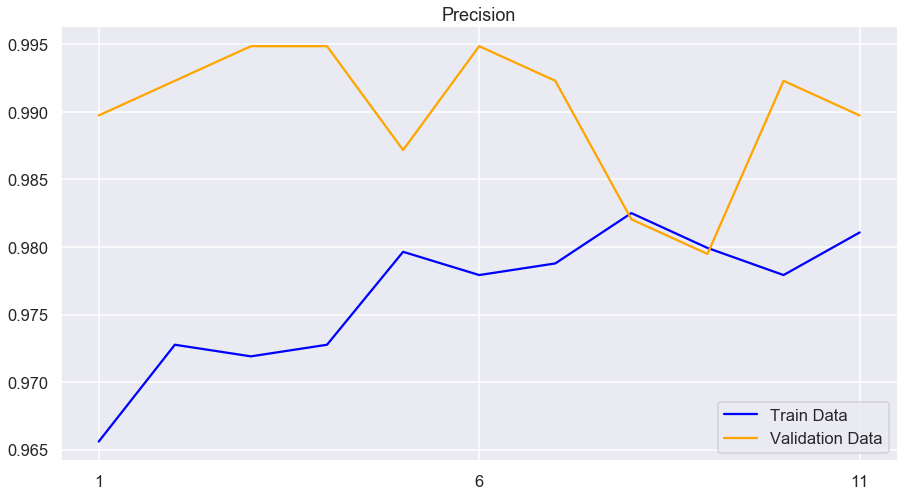

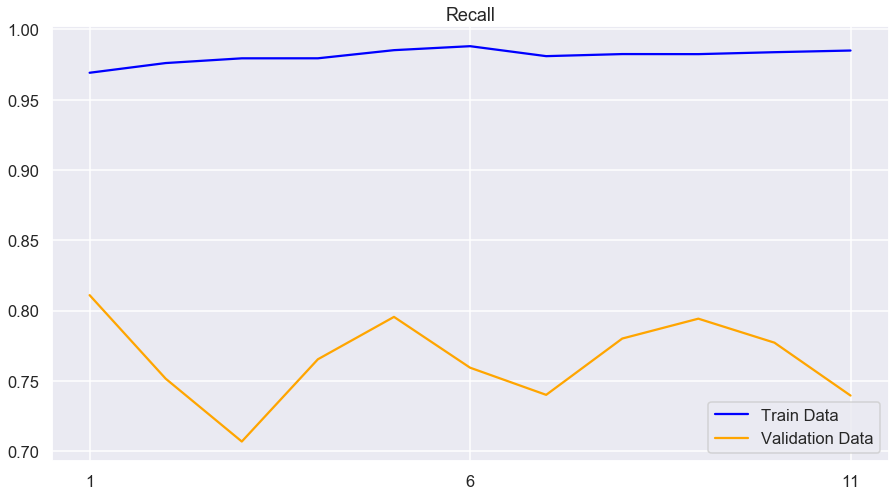

In [15]:
# evaluate model
model_evaluation(history_VGG16, p_r_iteration=2)

In [ ]:
# import best model and evaluate test set

In [16]:
# evaluate on test set

VGG16_test_accuracy = VGG16_model.evaluate_generator(test_gen_vgg16, steps=len(test_gen_vgg16))[1]
VGG16_test_precision = VGG16_model.evaluate_generator(test_gen_vgg16, steps=len(test_gen_vgg16))[2]
VGG16_test_recall = VGG16_model.evaluate_generator(test_gen_vgg16, steps=len(test_gen_vgg16))[3]

print("Test Set Accuracy: {}%".format(VGG16_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG16_test_precision*100))
print("Test Set Recall: {}%".format(VGG16_test_recall*100))

Test Set Accuracy: 77.56410241127014%
Test Set Precision: 73.94636273384094%
Test Set Recall: 98.97435903549194%


In [22]:
# plot confusion matrix for test set
Y_pred_vgg16 = VGG16_model.predict_generator(test_gen_vgg16, 10, workers=0)
y_pred_vgg16 = np.where(Y_pred_vgg16 > 0.40, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen_vgg16.classes, y_pred_vgg16)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen_vgg16.classes, y_pred_vgg16))

Confusion Matrix
[[ 33 201]
 [ 58 332]]
Classification Report
              precision    recall  f1-score   support

           0       0.36      0.14      0.20       234
           1       0.62      0.85      0.72       390

    accuracy                           0.58       624
   macro avg       0.49      0.50      0.46       624
weighted avg       0.53      0.58      0.53       624

